# Step 1: import libraries 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import numpy as np
import nltk
import requests
from itertools import chain

# Step 2: Prepare the corpus
### Load, tokenize, and preprocess the Reuters dataset.
### Build the vocab, inverse mapping and numericalise the dataset

In [8]:
import requests
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import random
from collections import Counter

In [9]:
# Download necessary NLTK resources
nltk.download('punkt') 

url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"

# Prepare the dataset
response = requests.get(url)
raw_text = response.text

# Define markers
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"

# Find the start and end positions
start_idx = raw_text.find(start_marker) + len(start_marker)
end_idx = raw_text.find(end_marker)

# Slice out the actual content
text = raw_text[start_idx:end_idx].strip()

[nltk_data] Downloading package punkt to /Users/xiaoxuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
#---For checking---
print(f"Extracted text length: {len(text)} characters")
print("Preview:\n", text[:1000])  # Show first 1000 characters
### End of checking

Extracted text length: 5555356 characters
Preview:
 The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
    THE FIRST PART OF HENRY THE SIXTH
    THE SECOND PART OF KING HENRY THE SIXTH
    THE THIRD PART OF KING HENRY THE SIXTH
    KING HENRY THE EIGHTH
    THE LIFE AND DEATH OF KING JOHN
    THE TRAGEDY OF JULIUS CAESAR
    THE TRAGEDY OF KING LEAR
    LOVE’S LABOUR’S LOST
    THE TRAGEDY OF MACBETH
    MEASURE FOR MEASURE
    THE MERCHANT OF VENICE
    THE MERRY WIVES OF WINDSOR
    A MIDSUMMER NIGHT’S DREAM
    MUCH ADO ABOUT NOTHING
    THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE
    PERICLES, PR

In [12]:
# Tokenize text into sentences, then words
sentences = sent_tokenize(text)
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
tokenized_sentences = [  # Remove punctuation and numbers to keep alphabetic words only
    [word for word in sentence if word.isalpha() and len(word) > 1]  # Also remove single letters
    for sentence in tokenized_sentences
]

total_words = sum(len(sentence) for sentence in tokenized_sentences)
print(f"Total sentences: {len(tokenized_sentences)}") #104698
print(f"Total words: {total_words}") #911436

# Check first 5 sentences
print("\nFirst 5 tokenized sentences:")
for i, sentence in enumerate(tokenized_sentences[:5]):
    print(f"{i+1}: {' '.join(sentence)}")

Total sentences: 104698
Total words: 911436

First 5 tokenized sentences:
1: the complete works of william shakespeare by william shakespeare contents the sonnets all well that ends well the tragedy of antony and cleopatra as you like it the comedy of errors the tragedy of coriolanus cymbeline the tragedy of hamlet prince of denmark the first part of king henry the fourth the second part of king henry the fourth the life of king henry the fifth the first part of henry the sixth the second part of king henry the sixth the third part of king henry the sixth king henry the eighth the life and death of king john the tragedy of julius caesar the tragedy of king lear love labour lost the tragedy of macbeth measure for measure the merchant of venice the merry wives of windsor midsummer night dream much ado about nothing the tragedy of othello the moor of venice pericles prince of tyre king richard the second king richard the third the tragedy of romeo and juliet the taming of the shrew the te

In [13]:
# Split the Gutenberg text into train/val/test: 80/10/10
random.seed(42)
random.shuffle(tokenized_sentences)  # Shuffle sentences for better distribution

total_sentences = len(tokenized_sentences)
train_size = int(total_sentences * 0.8)
val_size = int(total_sentences * 0.1)
#test_size = remaining 10%

# Split the data
train_data_sentences = tokenized_sentences[:train_size]
val_data_sentences = tokenized_sentences[train_size:train_size + val_size]
test_data_sentences = tokenized_sentences[train_size + val_size:]

print(f"\nDataset split:")
print(f"Train sentences: {len(train_data_sentences)}") #Train sentences: 83758
print(f"Val sentences: {len(val_data_sentences)}") #Val sentences: 10469
print(f"Test sentences: {len(test_data_sentences)}") #Test sentences: 10471


Dataset split:
Train sentences: 83758
Val sentences: 10469
Test sentences: 10471


In [14]:
# Build vocabulary from training data only
counter = Counter(token for sentence in train_data_sentences for token in sentence)
print(f"Unique words in training data: {len(counter)}") #Unique words in training data: 22006

vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=4)}
vocab.update({"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3})

# Create inverse vocabulary mapping
inv_vocab = {idx: word for word, idx in vocab.items()}

#print(f"Final vocabulary size: {len(vocab)}") #Final vocabulary size: 21510

Unique words in training data: 22006


In [ ]:
# Numericalize data: Convert words to IDs
def numericalize(data, vocab):
    numericalized = []
    for sentence in data:
        # Add <bos> at start and <eos> at end
        numericalized.append([vocab["<bos>"]] + [vocab.get(word, vocab["<unk>"]) for word in sentence] + [vocab["<eos>"]])
    return numericalized

# Convert all splits to numerical format
train_data = numericalize(train_data_sentences, vocab)
val_data = numericalize(val_data_sentences, vocab)
test_data = numericalize(test_data_sentences, vocab)

In [ ]:
########FOR CHECKING######

# Check the numericalized data
print(f"\nNumericalized data sample:")
print(f"Original sentence: {' '.join(train_data_sentences[0])}")
print(f"Numericalized: {train_data[0][:10]}...")  # Show first 10 tokens

# Check average sentence lengths
train_lengths = [len(sentence) for sentence in train_data]
val_lengths = [len(sentence) for sentence in val_data]
test_lengths = [len(sentence) for sentence in test_data]

# Print some Dataset statistics
print(f"\nAverage sentence lengths:")
print(f"Train: {sum(train_lengths)/len(train_lengths):.1f} tokens") #10.7 tokens
print(f"Val: {sum(val_lengths)/len(val_lengths):.1f} tokens") #10.8 tokens
print(f"Test: {sum(test_lengths)/len(test_lengths):.1f} tokens") #10.6 tokens
print(f"- Total vocabulary size: {len(vocab):,}") #Total vocabulary size: 22,010
print(f"- Training sentences: {len(train_data):,}") #Training sentences: 83,758
print(f"- Validation sentences: {len(val_data):,}") #Validation sentences: 10,469
print(f"- Test sentences: {len(test_data):,}") #Test sentences: 10,471
print(f"- Total training tokens: {sum(len(s) for s in train_data):,}") #Total training tokens: 896,922
print(f"- Total validation tokens: {sum(len(s) for s in val_data):,}") #Total validation tokens: 112,618
print(f"- Total test tokens: {sum(len(s) for s in test_data):,}") #Total test tokens: 111,292

In [23]:
# Show most common words
print("\nTop 10 most common words:")
for word, count in counter.most_common(10):
    print(f"{word}: {count}")
#ANS: the, and, to, of, you, my, in, that, is, not


Top 10 most common words:
the: 24295
and: 22729
to: 16670
of: 14868
you: 11736
my: 10506
in: 9972
that: 9792
not: 7918
is: 7914


# SECTION A: RNN Base Model

## Step 3: Define Dataset and DataLoader (Improved)
### Create a custom PyTorch dataset for batching.

In [ ]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        self.samples = []
        self.seq_len = seq_len

        # Build list of all valid subsequences
        for sentence in data:
            if len(sentence) > seq_len:  # only use long enough sentences
                for i in range(len(sentence) - seq_len):
                    x = sentence[i:i + seq_len]
                    y = sentence[i + 1:i + seq_len + 1]
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
    

In [ ]:
# Hyperparameters
seq_len = 128

# Create datasets
train_dataset = ShakespeareDataset(train_data, seq_len)
val_dataset = ShakespeareDataset(val_data, seq_len)
test_dataset = ShakespeareDataset(test_data, seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
#DataLoader: Automatically batches and shuffles data for training.

## Step 4: Build the RNN Model

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [ ]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [ ]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [ ]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

In [30]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

         Train Loss     Train PPL  Val Loss         Val PPL
Epoch 1    9.742667  17028.904552  9.807553     18170.46439
Epoch 2    8.583537   5342.972324  8.562115     5229.730871
Epoch 3    7.042081   1143.764956  8.069716     3196.193297
Epoch 4    6.321171    556.223773  8.063274     3175.671798
Epoch 5     5.98656    398.042849  8.131101     3398.538124
Epoch 6    5.760252    317.428212  8.077703     3221.822661
Epoch 7    5.536443    253.773594  8.040965     3105.610091
Epoch 8    5.424107    226.808728  8.002868     2989.519886
Epoch 9    5.285977    197.547136   7.93389     2790.259191
Epoch 10   5.183355    178.279853  7.896645     2688.247013
10              ---           ---       ---  Time: 3.14 min


## Step 6: Plot training and validation loss curves

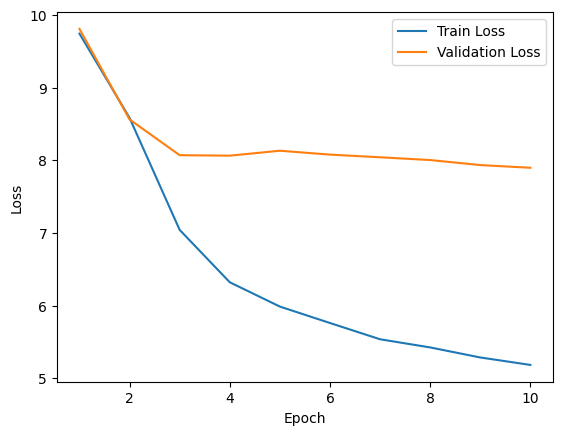

In [31]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [32]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [33]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test PPL: {val_PPL:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test PPL: {test_PPL:.4f}")

Val Loss: 7.8966, Test PPL: 2688.2470
Test Loss: 9.0586, Test PPL: 8592.5021


## Step 8: Generate Text 

In [34]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [38]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the tragedy of windsor him own afterwards king wolsey the cuckoo the world the turtle and the cuckoo of king of the of the third gaunt of with the two of the of him his the gentlemen of of youth of king richard the eighth of macbeth for cruel beauty thereby the wronger the second war the phoenix of of and the sir can fortune as wanton art of venice the second of whereby the about of and first the child of of venice the fourth the wind of venice the tragedy of steward the feeding that his the fill of the tragedy of earl willoughby cherish of king elizabeth in to under the sixth the tempest york in the tragedy of lucrece and with the tragedy of tyre the fives of thebes and from venice sister by of king of that and by ends the our of that all
[Sampling with T=1.0] 
the tewksbury spirits office of honour with in sir with time occasion to york war the two oblivion forth with england and palamon from of rape old sum ewe theban the woo took gentlemen troilus sir with th

# SECTION B: ABLATION STUDY ON DROPOUT = 0.1

## Steps 1 - 3 are the same as above
## Step 4: Build the RNN Model

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [ ]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [ ]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [ ]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

In [ ]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)


## Step 6: Plot training and validation loss curves

In [ ]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [ ]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [ ]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test PPL: {val_PPL:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test PPL: {test_PPL:.4f}")

## Step 8: Generate Text 

In [ ]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [ ]:
print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=0.7))
print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=1.0))
print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=1.3))

# SECTION C: ABLATION STUDY ON CONTEXT LENGTH = 256